In [1]:
import matplotlib.pyplot as plt
import numpy as np

**activation functions**

Let's start by writing some functions for activation functions that we would like to be able to use.

Fill in the functions below to implement the associated activation functions. Any time you need a special function (e.g. exponentation), try to find a version in NumPy so that your activation functions will work on single values as well as arrays.

*bonus*: try to implment the ReLU activation function so that it works elementwise on a NumPy -- this is called "vectorizing" your code. Hint: check out the `np.where` function.

In [2]:
def linear(z):
    '''
    linear activation function
    '''
    return z

# more specifically, the logistic sigmoid that has values between 0 and 1
def sigmoid(z):
    '''
    sigmoid activation function
    '''
    return 1/(1 + np.exp(-z))

def tanh(z):
    '''
    tanh activation function
    '''
    return np.tanh(z)

# update this to work on a NumPy array without using a loop
'''
def relu(z):
    if z < 0:
        return 0
    else:
        return z
'''

def relu(z):
    return z * (z > 0)

tests

In [3]:
a = np.array([-1.0, 0.0, 1.0])

np.testing.assert_equal(linear(5), 5)
np.testing.assert_equal(linear(-3.0), -3.0)
np.testing.assert_array_equal(linear(a), a)

np.testing.assert_equal(sigmoid(0.0), 0.5)
np.testing.assert_allclose(sigmoid(a), [0.26894142, 0.5, 0.73105858])

np.testing.assert_equal(tanh(0.0), 0.0)
np.testing.assert_allclose(tanh(a), [-0.76159416, 0.0, 0.76159416])

**single neuron**

As a warm-up for implementing a full neural network layer, let's implement the computation performed by a single neuron.

If our neuron has $m$ inputs, then its output will be defined by:

- the inputs, which we can represent as an $m$-dimensional array: $x=[x_1, x_2, ..., x_m]$
- the weights for each input, which we can represent as another $m$-dimensional vector: $w = [w_1, w_2, ..., w_n]$
- the bias, which is a scalar: $b$
- the activation function: $f$

With these definitions, the output of our neuron is:
$$a = f(w_1 x_1 + w_2 x_2 + ... + w_m x_m + b)$$
$$=f(w \cdot x + b)$$

In [4]:
def neuron(x, w, b, f):
    '''
    tranformation for a single layer of a neural network

    parameters
    ----------
    x (1d array): input vector
    w (1d array): neuron weights
    b (float):    bias
    f (func):     activation function
    '''
    return f(np.array(x).dot(np.array(w)) + b)
    

tests

In [5]:
np.testing.assert_equal(
    neuron([0, 0, 0], [0, 0, 0], 10, linear),
    10
)
np.testing.assert_equal(
    neuron([1, 2, 3], [0, 1, 0], 0, linear),
    2
)
np.testing.assert_equal(
    neuron([1, 2, 3], [1, 2, 3], 0, linear),
    14
)
np.testing.assert_equal(
    neuron([1, 1, 1], [-1, 0, 1], 0, linear),
    0
)
np.testing.assert_equal(
    neuron([-1, 0, 1], [1, 1, 1], 0, linear),
    0
)
np.testing.assert_equal(
    neuron([0, 0, 0], [1, 1, 1], -1, tanh),
    np.tanh(-1.0)
)

**vectorizing**

If your code for a single neuron used a loop, go back and try to write it without, using helper functions from NumPy that let you avoid writing a loop. Hint: check out the NumPy's `np.dot` function.

This is known as "vectorizing" your code and, in general, is a good idea in a language like Python which is not built for speed. Fortunately, libraries like NumPy have critical portions of their code written in lower level languages (like C, C++, or FORTRAN) where loops are faster (though the code is harder to write and make sure it is correct).

**neural net layer with batch inputs**

Now for the real deal: extending our function for a single neuron in two ways:
- first, so that it can process a "batch" of multiple inputs rather than just a single input
- second, so that it can do the computation for an entire hidden layer of neurons instead of just one

Let's look at the math for each of these extensions in turn.

*batch inputs*:

We want to process a set (or "batch") of inputs at the same time, both for the sake of convenience and so we can hopefully vectorize the code to make processing a batch faster than simply looping through all of the inputs in the batch.

If we have $k$ inputs in a batch, each of which are $m$-dimensional, then we can organize these inputs into a $k$-by-$m$ matrix simply by stacking the individual input vectors:

\\
$$
\begin{bmatrix}
  -\, x^1 \, -\\
  -\, x^2 \, -\\
  \vdots \\
  -\, x^k \, -\\
\end{bmatrix}
=
\begin{bmatrix}
x_{11} & x_{12} & \cdots & x_{1m} \\
x_{21} & x_{22} & \cdots & x_{2m} \\
\vdots & \vdots  &  \ddots & \vdots \\
x_{k1} & x_{k2} & \cdots & x_{km}
\end{bmatrix}
$$

\\
where each row contains the components for one input

*multiple neurons*

Now let's considering an entire layer of neurons that recieve this same input and, again, we want to compute the outputs for the entire layer together for convenience and efficiency.

If we have $n$ neurons, we will now have $m$ of weights (for a  $m$-dimensional input) for each neuron. Similar to what we just saw for extending to multiple inputs, we can collect these weights in an $m$-by-$n$ matrix, but this times lets put each weight vector in its own column (we'll see why shortly):

\\
$$W =
\begin{bmatrix}
| & | & \quad & | \\
w^1 & w^2 & \cdots & w^n \\
| & | & \quad & |
\end{bmatrix}
=
\begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1n} \\
w_{21} & w_{22} & \cdots & w_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
w_{m1} & w_{m2} & \cdots & w_{mn}
\end{bmatrix}
$$

\\
where each column contains the weights for one of the neurons in the layer. We also have one bias for each neuron, which we can organize in a vector:

\\
$$
b =
\begin{bmatrix}
b_1 & b_2 & \cdots & b_n
\end{bmatrix}
$$.

\\
*putting it all together*

Next, we want to compute the total weighted input to each neuron in the layer for each input. We can organize these values into a matrix, with one row for each sample and one column for each neuron in our layer. 

\\
$$
\begin{bmatrix}
x^1 \cdot w^1 & x^1 \cdot w^2 & \cdots & x^1 \cdot w^n \\
x^2 \cdot w^1 & x^2 \cdot w^2 & \cdots & x^2 \cdot x^n \\
\vdots & \vdots & \ddots & \vdots \\
x^m \cdot w^1 & x^m \cdot w^2 & \cdots & x^m \cdot w^n
\end{bmatrix}
$$

\\
But taking the dot product between all rows of one matrix with all columns of another matrix is exactly the definition of matrix multiplication, so we have:

\\
$$
\begin{bmatrix}
x^1 \cdot w^1 & x^1 \cdot w^2 & \cdots & x^1 \cdot w^n \\
x^2 \cdot w^1 & x^2 \cdot w^2 & \cdots & x^2 \cdot x^n \\
\vdots & \vdots & \ddots & \vdots \\
x^m \cdot w^1 & x^m \cdot w^2 & \cdots & x^m \cdot w^n
\end{bmatrix}
=
\begin{bmatrix}
  -\, x^1 \, -\\
  -\, x^2 \, -\\
  \vdots \\
  -\, x^k \, -\\
\end{bmatrix} 
\begin{bmatrix}
| & | & \quad & | \\
w^1 & w^2 & \cdots & w^n \\
| & | & \quad & |
\end{bmatrix}
=XW
$$

\\
We also need to add the bias terms, which is the same for each row/neuron. We can write this as:

\\
$$
\begin{bmatrix}
x^1 \cdot w^1 + b_1 & x^1 \cdot w^2 + b_2 & \cdots & x^1 \cdot w^n + b_n \\
x^2 \cdot w^1 + b_1 & x^2 \cdot w^2 + b_2 & \cdots & x^2 \cdot x^n + b_n \\
\vdots & \vdots & \ddots & \vdots \\
x^m \cdot w^1 + b_1 & x^2 \cdot w^2 + b_2 & \cdots & x^m \cdot w^n + b_n
\end{bmatrix} \\
=
\begin{bmatrix}
x^1 \cdot w^1 & x^1 \cdot w^2 & \cdots & x^1 \cdot w^n \\
x^2 \cdot w^1 & x^2 \cdot w^2 & \cdots & x^2 \cdot x^n \\
\vdots & \vdots & \ddots & \vdots \\
x^m \cdot w^1 & x^m \cdot w^2 & \cdots & x^m \cdot w^n
\end{bmatrix}
+
\begin{bmatrix}
b_1 & b_2 & \cdots & b_m
\end{bmatrix}
= XW + b
$$

\\
where when have have addition of a matrix to a row/column vector, we interpret this via *broadcasting*: we assume that the row/column is repeated across all rows/columns to match the shape of the matrix. This is exactly how many numeric programming langauges/packages (including NumPy) handle this as well.

Finally, the outputs for all neurons across all batches can be computed by applying the activation function elementwise for a final result of:

\\
$$
A = f(XW + b)
$$

\\
And here is the best part: the same function in NumPy that computes the dot-product between two 1-dimensional arrays also computes matrix multiplication when given 2-dimensional arrays instead. This means that the function you wrote for a single neuron will already work for multiple neurons across a batch of inputs!

Go ahead and try it -- simply change the weights and inputs to 2d-arrays (and you can change the biases to a 1d-array if you want a different bias for each neuron.

In [6]:
def nn_layer(X, W, b, f):
    '''
    tranformation for a single layer of a neural network

    parameters
    ----------
    X (2d array): input vectors
    W (2d array): neuron weights
    b (1d array): biases
    f (func):     activation function
    '''
    return f(np.dot(X, W) + b)

tests

In [7]:
X = [
     [0, 0, 0],
     [1, 1, 1],
     [-1, 0, 1]
]
W = [
     [0, 1, 0],
     [0, 1, 1],
     [0, 1, 2]
]
b = [0, 0, 0]
A = nn_layer(X, W, b, linear)
np.testing.assert_array_equal(A, [[0, 0, 0], [0, 3, 3], [0, 0, 2]])

b = [[1, 2, 3]]
A = nn_layer(X, W, b, linear)
np.testing.assert_array_equal(A, [[1, 2, 3], [1, 5, 6], [1, 2, 5]])

**neural net with one hidden layer**

Next, let's make a function to implement a two-layer neural network - one hidden layer and the output layer. It should takes as inputs:
- An input matrix, $X$
- Two weight matrices, $W_1$ and $W_2$ (one for each layer)
- Two bias vectors, $b_1$ and $b_2$ (one for each layer)
- Two activation functions (one for the hidden layer, one for the output)

This function should call your `nn_layer` function twice with the appropriate arguments, chaining the output of the first layer into the input to the secocond layer, and then returning the final output

In [8]:
def nn_two_layers(X, W_1, b_1, f_1, W_2, b_2, f_2):
    '''
    forward pass of a two-layer neural network

    parameters
    ----------
    X (2d array):   input matrix
    W_1 (2d array): weight matrix for first layer
    b_1 (1d array): biases for first layer
    f_1 (func):     activation function for first layer
    W_2 (2d array): weight matrix for second layer
    b_2 (1darray):  biases for second layer
    f_2 (func):     activtion function for second/output layer
    '''
    inp = f_1(np.dot(X, W_1) + b_1)
    oup = f_2(np.dot(inp, W_2) + b_2)
    return oup

To test out your brand new neral net function, let's test it out on a 1-dimensional input and a 1-dimensional output so that we can plot the results with a line graph. We will use random values for the weight and biases.

Follow along below as we walk through how to do this with some NumPy functions and Python's popular plotting package, Matplotlib.

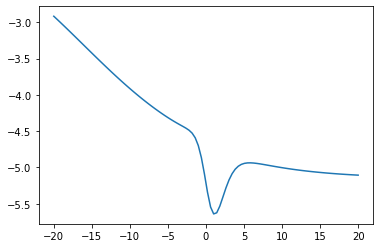

In [9]:
# Set the input dimension, the number of hidden units, and the number of ouptput units
n_input, n_hidden, n_output = 1, 5, 1

# We want get the NN's output for a range of input values, so that we cant plot
# input vs output. We can get evenly space values using `np.linspace`. We also
# want to process these inputs as a "batch", so we use `np.newaxis` to turn this
# 1-d array into a 2-d array with a single column.
n_grid = 100
X = np.linspace(-20, 20, n_grid)[:, np.newaxis]

# We can generate random values (drawn from a standard gaussian distribution --
# mean = 0, standard deviation = 1), with `np.random.randn(shape)`
W_1 = np.random.randn(n_input, n_hidden)
b_1 = np.random.randn(n_hidden)
W_2 = np.random.randn(n_hidden, n_output)
b_2 = np.random.randn(n_output)

# Use our NN to compute the outputs for these inputs
Y_hat = nn_two_layers(X, W_1, b_1, tanh, W_2, b_2, linear)

# Plot the input values (x-axis) against the output values (y-axis)
plt.plot(X, Y_hat)
plt.show()

In [10]:
W_2.shape

(5, 1)

### Exercises

**function exploration**

Experiment with your 2-layer neural network using the code above to answer the following questions.

1. Use a `relu` activation on the hidden layer and a `linear` activation on the output layer. Now vary the number of hidden units between, say 1 and 20. How does the number of hidden units effect the function that your neural net represents? Why is this?

2. Now keep using a `linear` output activation, but compare and contrast using `relu` vs `tanh` for the activation on the hidden layer. What do you notice is the main difference between the represented functions? Why is this?

3. Finally, switch to using a `sigmoid` for the output activation. What values does restrict the output to? What type of supervised learning problem would this be ideally suited for?

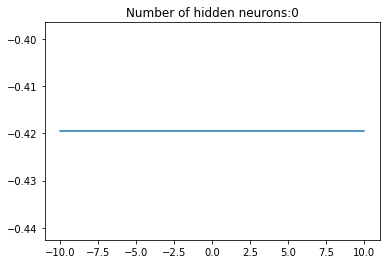

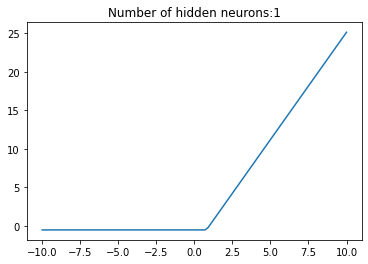

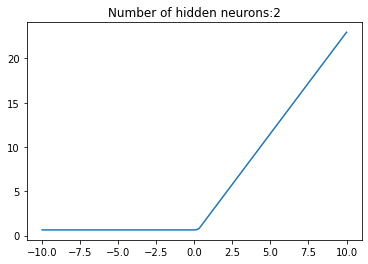

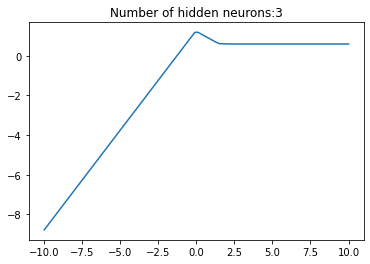

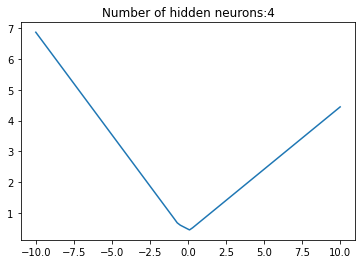

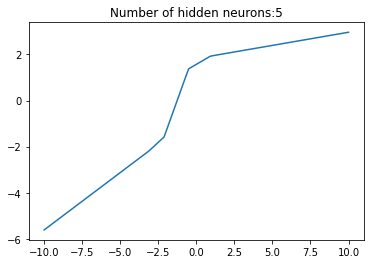

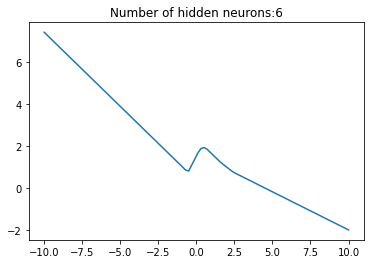

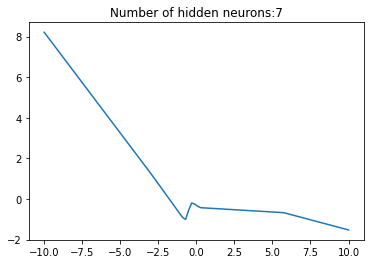

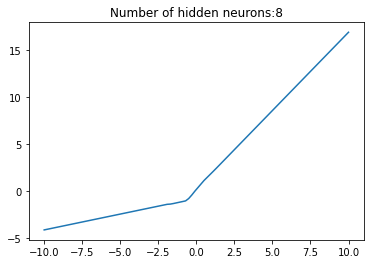

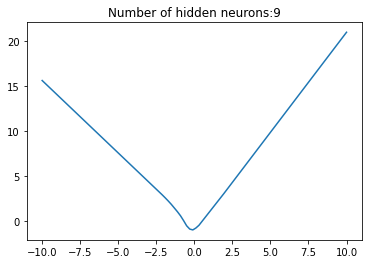

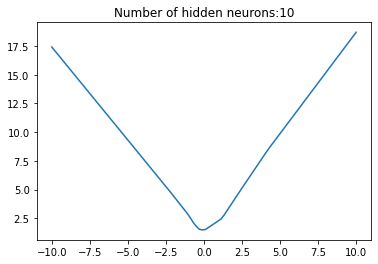

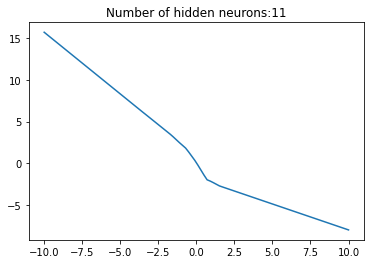

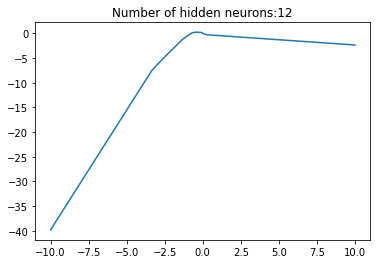

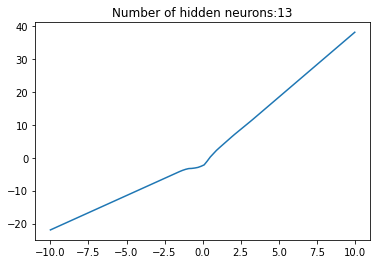

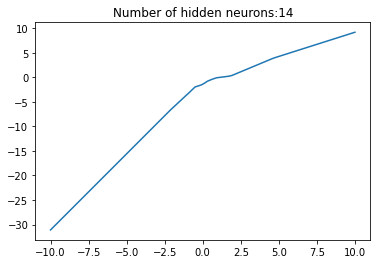

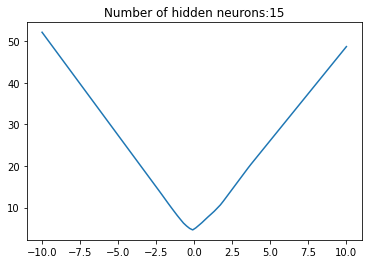

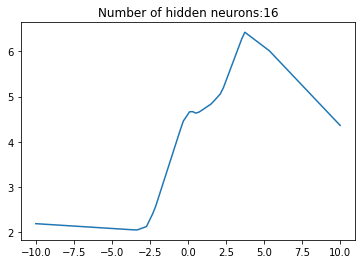

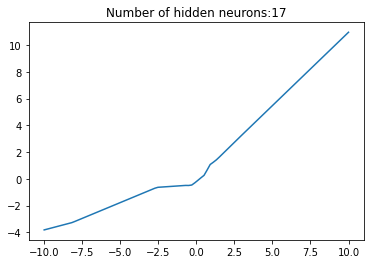

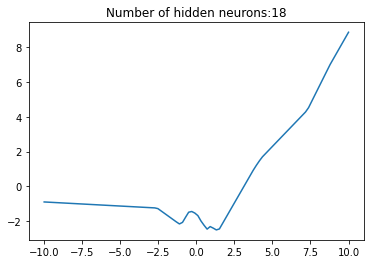

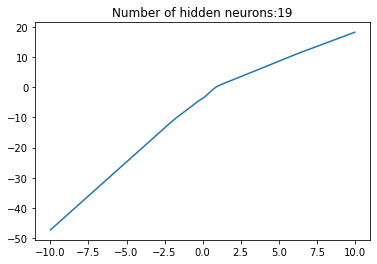

In [11]:
# 1

for i in range(20):
    n_input, n_hidden, n_output = 1, i, 1
    n_grid = 100
    X = np.linspace(-10, 10, n_grid)[:, np.newaxis]

    W_1 = np.random.randn(n_input, n_hidden)
    b_1 = np.random.randn(n_hidden)
    W_2 = np.random.randn(n_hidden, n_output)
    b_2 = np.random.randn(n_output)

    Y_hat = nn_two_layers(X, W_1, b_1, relu, W_2, b_2, linear)

    plt.plot(X, Y_hat)
    plt.title("Number of hidden neurons:" + str(i))
    plt.show()

Increasing number of hidden neurons complicates the shape of the output.

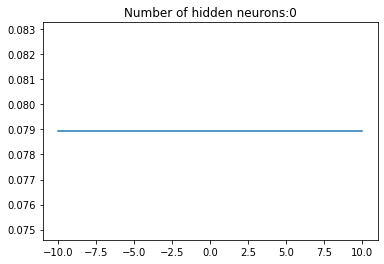

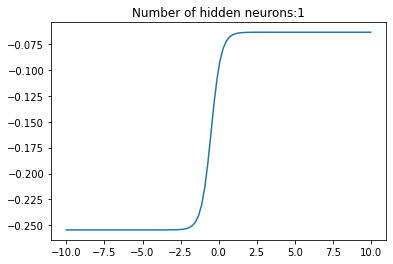

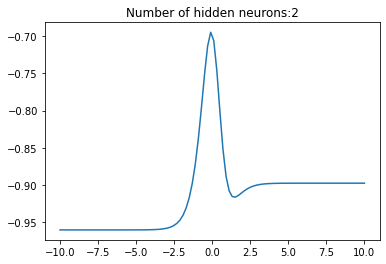

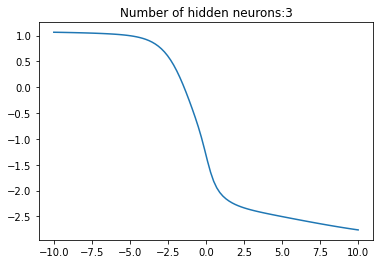

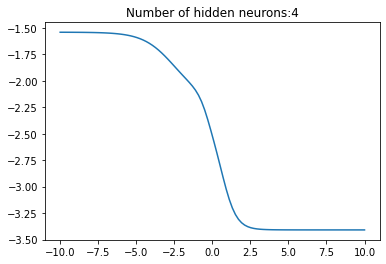

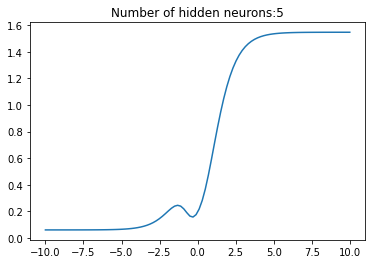

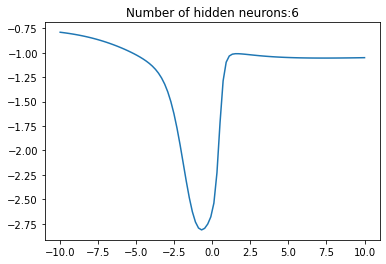

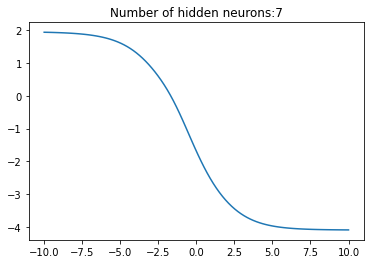

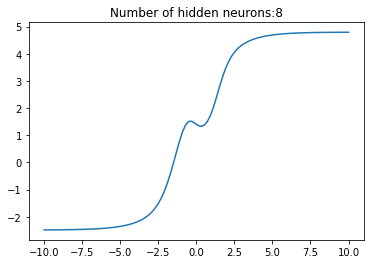

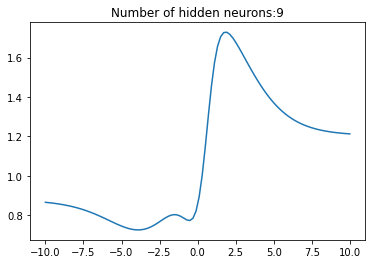

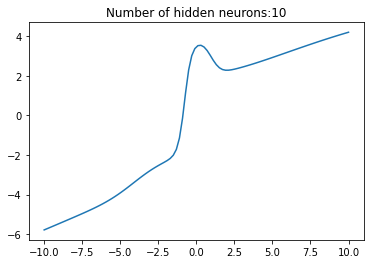

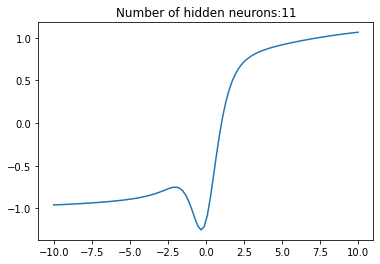

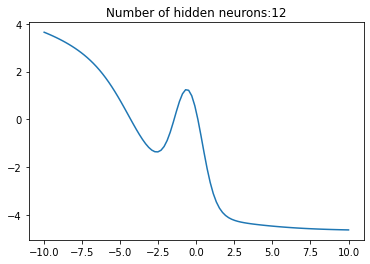

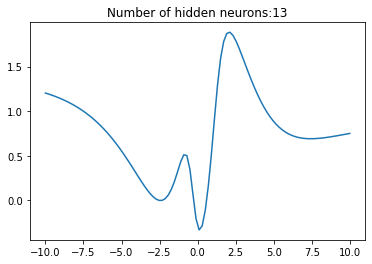

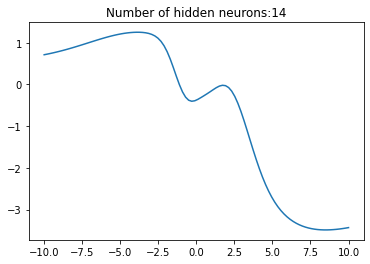

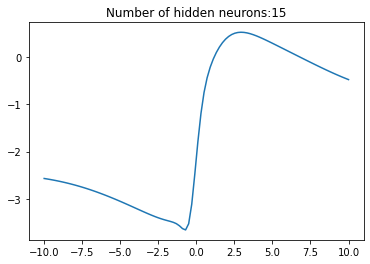

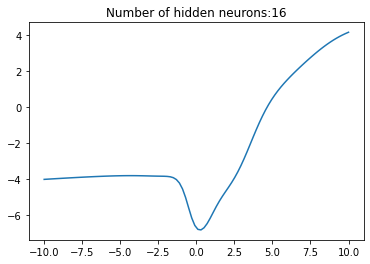

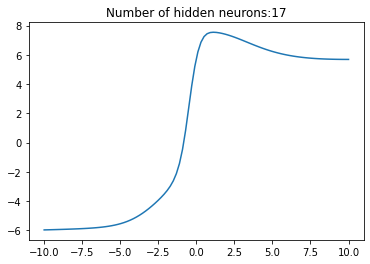

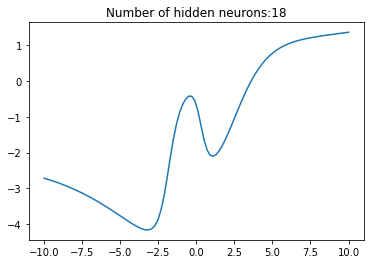

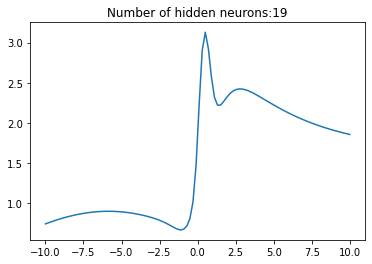

In [12]:
# 2

for i in range(20):
    n_input, n_hidden, n_output = 1, i, 1
    n_grid = 100
    X = np.linspace(-10, 10, n_grid)[:, np.newaxis]

    W_1 = np.random.randn(n_input, n_hidden)
    b_1 = np.random.randn(n_hidden)
    W_2 = np.random.randn(n_hidden, n_output)
    b_2 = np.random.randn(n_output)

    Y_hat = nn_two_layers(X, W_1, b_1, tanh, W_2, b_2, linear)

    plt.plot(X, Y_hat)
    plt.title("Number of hidden neurons:" + str(i))
    plt.show()

Outputs are curvier than the relu activation. 

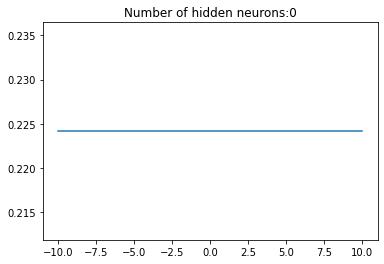

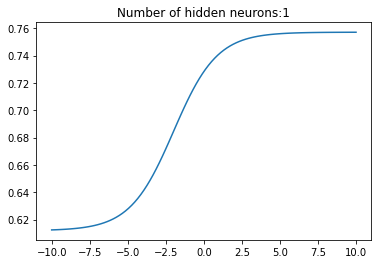

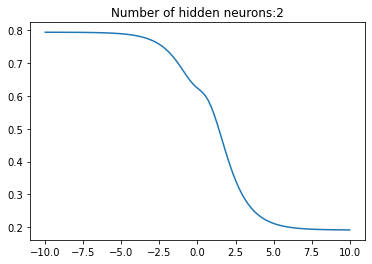

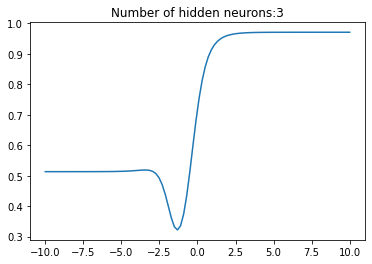

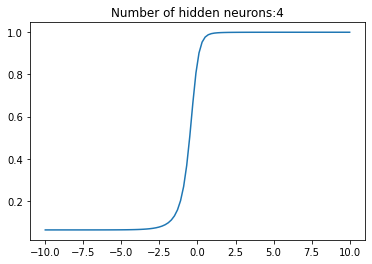

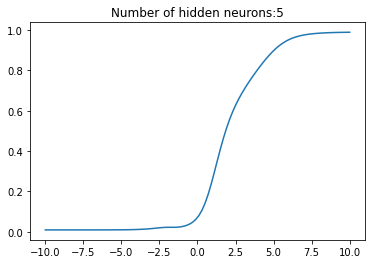

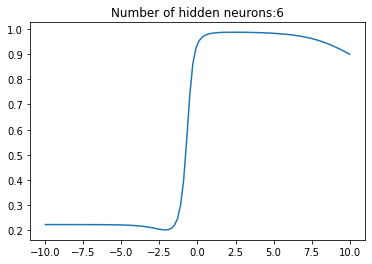

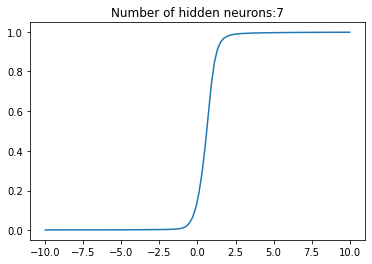

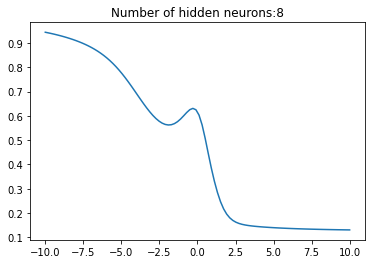

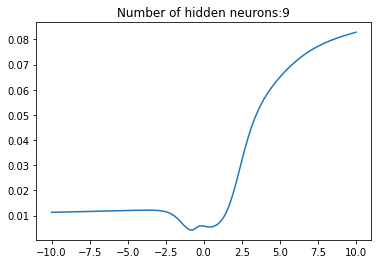

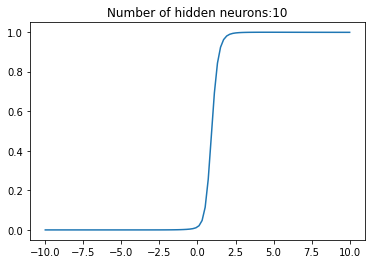

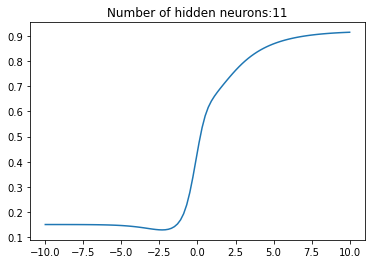

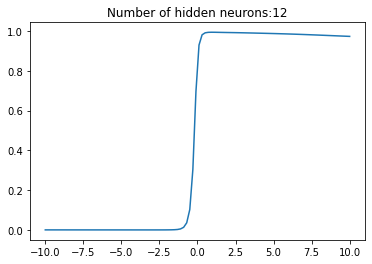

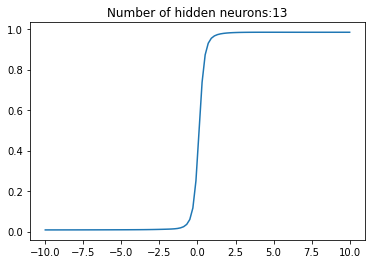

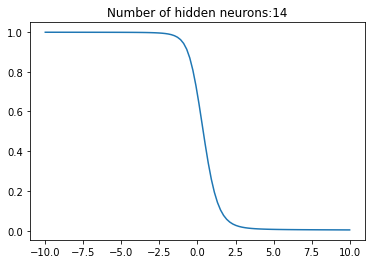

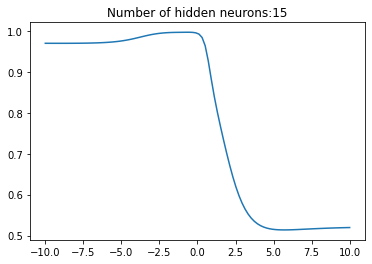

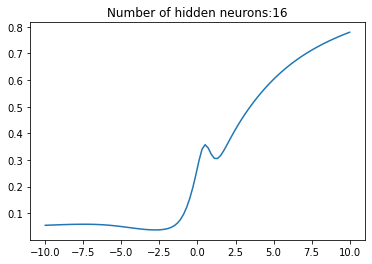

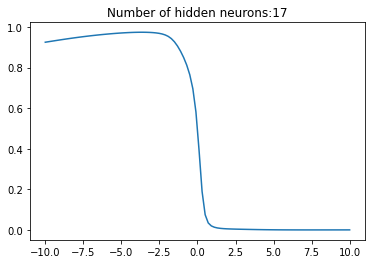

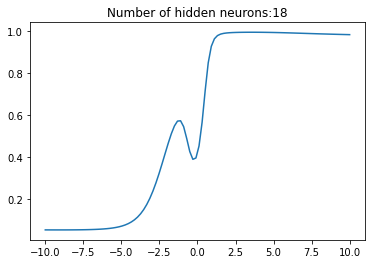

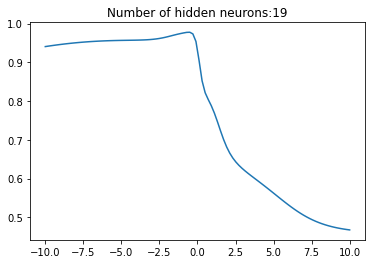

In [13]:
# 3

for i in range(20):
    n_input, n_hidden, n_output = 1, i, 1
    n_grid = 100
    X = np.linspace(-10, 10, n_grid)[:, np.newaxis]

    W_1 = np.random.randn(n_input, n_hidden)
    b_1 = np.random.randn(n_hidden)
    W_2 = np.random.randn(n_hidden, n_output)
    b_2 = np.random.randn(n_output)

    Y_hat = nn_two_layers(X, W_1, b_1, tanh, W_2, b_2, sigmoid)

    plt.plot(X, Y_hat)
    plt.title("Number of hidden neurons:" + str(i))
    plt.show()

The output is scaled to range [0,1] with the sigmoid function. This would suit for when the output's natural interpretation fits the range [0,1], such as probabilities.

**deep neural nets**

Our neural network currently works for only a single hidden layer. This is a rather shallow network, and the next step is to extend it to a deep network that can handle any number of layers.

The handle an arbitrary number of layers, switch to taking a 3-dimensional array for the layer weights -- now the first index will specify which layer the remaing 2-dimension subarray is associated with (e.g. `W[2]` would be the 2-d array of weights for the connections from layer 2 to layer 3). Similary, add another dimension to the biases to specify the layer, making $b$ a 2-dimensional array.

Here you will probably need to use a for loop to iterate through the layers. You will probably want to handle the final/output layer separately, as it needs its own activation function (so your code can match different output targets).

In [14]:
def deep_nn(X, W, b, f_hidden, f_output):
    '''
    forward pass for a deep neural net with an arbitrary number of layers

    parameters
    ----------
    X (2d array):     input vectors
    W (3d array):     weight matrices -- W[layer, input, neuron]
    b (2d array):     bias vectors -- b[layer, neuron]
    f_hidden (func):  activation function for all hidden layers
    f_output (func):  activation function for final/output layer
    '''
    for i in range(2):
        
        X = f_hidden(np.dot(X, W[i]) + b[i])
    
    return f_output(X)

In [15]:
n_input, n_hidden, n_layer, n_output = 1, 5, 3, 1

n_grid = 100
X = np.linspace(-10, 10, n_grid)[:, np.newaxis]

W1 = np.random.randn(n_input, n_hidden)
W2 = np.random.randn(n_hidden, n_hidden)
W3 = np.random.randn(n_hidden, n_output)
W = [W1,W2,W3]
b = np.random.randn(n_layer, n_hidden)

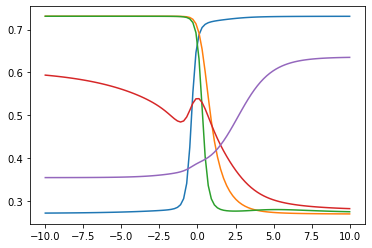

In [16]:
Y_hat = deep_nn(X, W, b, tanh, sigmoid)

# Plot the input values (x-axis) against the output values (y-axis)
plt.plot(X, Y_hat)
plt.show()